## Kickstarter NLP - Success or Failure

The objective is to classify a kickstarter campaign as a success or failure based on its brief description.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import scipy
import seaborn as sns
import re
from nltk.corpus import stopwords
from collections import Counter
%matplotlib inline
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
#importing kickstarter data
kickstarter = pd.read_csv('/Users/salilketkar/thinkful/DS_Unit4/Unit 4 Capstone/df_text_eng.csv')
kickstarter.columns = ['id','blurb','state']
print('Shape of Kickstarter data set:',kickstarter.shape)
kickstarter.head(n=50)


Shape of Kickstarter data set: (215513, 3)


,id,blurb,state
0,1,"Using their own character, users go on educati...",failed
1,2,"MicroFly is a quadcopter packed with WiFi, 6 s...",successful
2,3,"A small indie press, run as a collective for a...",failed
3,4,Zylor is a new baby cosplayer! Back this kicks...,failed
4,5,Hatoful Boyfriend meet Skeletons! A comedy Dat...,failed
5,6,FastMan is a Infinite running platformer. Go i...,failed
6,7,FADE. A dark and somber RPG about survival and...,failed
7,8,The next generation of space combat with onlin...,failed
8,9,Whip around planets and smash your way to vict...,failed
9,10,"Sneak in, find treasures, avoid cats and colle...",failed


In [4]:
#creating binary column out of 'state'
kickstarter['pass'] = np.where(kickstarter['state'] == 'successful',1,0)

This is a binary classification problem so the 'state' column was converted to binary.

In [5]:
#checking null values
kickstarter.dropna(inplace=True)
kickstarter.isnull().any()


id       False
blurb    False
state    False
pass     False
dtype: bool

As part of the data cleaning process, it is important to make sure there are no null values. In this case there were, so they were removed. 

In [6]:
#converting everything to lower-case
kickstarter['blurb'] = kickstarter['blurb'].apply(str.lower)

#cleaning blurbs 
kickstarter['blurb'] = kickstarter['blurb'].apply(lambda x: re.sub('\d+', ' ', x))
kickstarter['blurb'] = kickstarter['blurb'].apply(lambda x: x.replace('\n',''))
kickstarter['blurb'] = kickstarter['blurb'].apply(lambda x: x.strip('_'))

I converted all descriptions to lowercase and removed underscores and \n.  

In [7]:
#checking class balance 
print('The two unique states are:',np.unique(kickstarter['state']))
print(kickstarter.shape)
pd.value_counts(kickstarter.state)

The two unique states are: ['failed' 'successful']
(215510, 4)


successful    108310
failed        107200
Name: state, dtype: int64

The classes are pretty close to being balanced given the size of this dataset. 

In [8]:
pass_sample = kickstarter.loc[kickstarter['pass'] == 1].sample(n=30000)
fail_sample = kickstarter.loc[kickstarter['pass'] == 0].sample(n=30000)
df_sample = pass_sample.append(fail_sample)
df_sample.reset_index(drop=True,inplace=True)

It was necessary to sample a percent of the data set so run times would not be too long. 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = []
for blurb in df_sample['blurb']:
    corpus.append(blurb)
    
vectorizer = CountVectorizer(lowercase=True,stop_words='english',strip_accents='ascii',min_df=5)
X_bow = vectorizer.fit_transform(corpus)
feat_names = vectorizer.get_feature_names()

The bag of words method was executed using CountVectorizer.  Given the large size of this data set, the minimum count for features was at least 5.  All words were turned into lowercase.  Stop words were excluded and accent marks were removed.

In [10]:
#creating bag of words data frame
df_bow = pd.DataFrame(data=X_bow.toarray(), columns=feat_names)
df_bow['pass'] = df_sample['pass']
df_bow['blurb'] = df_sample['blurb']

#creating features and target for feature selection/engineering and future modeling
X_bow = df_bow.drop(['pass','blurb'],axis=1)
Y_bow = df_bow[['pass']]

In [11]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=150)
pca_bow = pca.fit_transform(X_bow)
print(np.sum(pca.explained_variance_ratio_))

0.2870041407546874


PCA was not too successful.  Even with 500 components the explained variance is quite low.  Another method for dimension reduction is singular value decomposition.

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

svd = TruncatedSVD(150)
svd_bow= svd.fit_transform(X_bow)
print(np.sum(svd.explained_variance_ratio_))

0.2857655711189164


Since PCA was not very effective, I turned to truncated singular value decomposition.  This did not have favorable results either. The idea is to reduce the dimensions of this data set so it is more suitable for modeling.

In [13]:
#tfidf

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
                             min_df=4, # only use words that appear at least five times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
tfidf = vectorizer.fit_transform(corpus)
tfidf_feat_names = vectorizer.get_feature_names()

In [14]:
#creating tfidf data frame
df_tfidf = pd.DataFrame(data=tfidf.toarray(), columns=tfidf_feat_names)
df_tfidf['pass'] = df_sample['pass']
df_tfidf['blurb'] = df_sample['blurb']

#creating features and target for feature selection/engineering and future modeling
X_tfidf = df_bow.drop(['pass','blurb'],axis=1)
Y_tfidf = df_bow[['pass']]

I used TfidfVectorizer from sklearn to get features and their corresponding tfidf values.  A dataframe was created with features and tfidf values.  From there, an X and Y dataframe was created for modeling purposes.

In [15]:
#pca 
tfidf = PCA(n_components=150)
pca_tfidf = tfidf.fit_transform(X_tfidf)
print(np.sum(tfidf.explained_variance_ratio_))

0.2869417345340343


In [16]:
svd1 = TruncatedSVD(150)
svd_tfidf= svd1.fit_transform(X_bow)
print(np.sum(svd1.explained_variance_ratio_))

0.28565978407809217


I tried PCA and TruncatedSVD to reduce the dimensions of the data set.  Both returned similar explained variance values.

In [17]:
from sklearn.model_selection import train_test_split

X_train_bow_pca, X_test_bow_pca, y_train_bow_pca, y_test_bow_pca = train_test_split(pca_bow, Y_bow, test_size=0.2)
X_train_tfidf_svd, X_test_tfidf_svd, y_train_tfidf_svd, y_test_tfidf_svd = train_test_split(svd_tfidf, Y_bow, test_size=0.2)

For this challenge, I chose to use PCA values from the bag of words method and truncated SVD values from the tfidf method.  The data was split into train and test sets and will be used below on various types of models. 

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


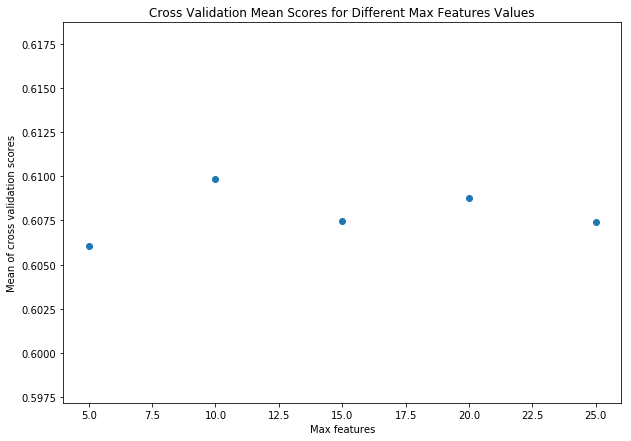

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_bow_pca_cv = []
for max_feat in [5,10,15,20,25]:
    rfc_bow_pca = RandomForestClassifier(max_features = max_feat, n_estimators=100, min_samples_split=2)
    rfc_bow_pca.fit(X_train_bow_pca, y_train_bow_pca)
    rf_bow_pca_cv.append(np.mean(cross_val_score(rfc_bow_pca, X_train_bow_pca, y_train_bow_pca, cv=5)))

plt.figure(figsize=(10,7))
plt.scatter([5,10,15,20,25], rf_bow_pca_cv)
plt.xlabel('Max features')
plt.ylabel('Mean of cross validation scores')
plt.title('Cross Validation Mean Scores for Different Max Features Values')
plt.show()

I began with max_featues as the first parameter to optimize.  The plot shows the mean cross validation scores for each iteration of Random Forest using a different max_features value. 

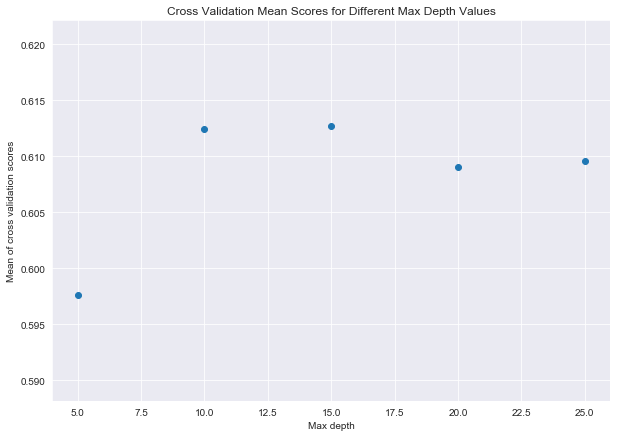

In [19]:
rf_bow_pca_cv_md = []
for md in [5,10,15,20,25]:
    rfc_bow_pca = RandomForestClassifier(max_features = 20, n_estimators=100, min_samples_split=2,max_depth=md)
    rfc_bow_pca.fit(X_train_bow_pca, y_train_bow_pca)
    rf_bow_pca_cv_md.append(np.mean(cross_val_score(rfc_bow_pca, X_train_bow_pca, y_train_bow_pca, cv=5)))

sns.set_style('darkgrid')
plt.figure(figsize=(10,7))
plt.scatter([5,10,15,20,25], rf_bow_pca_cv_md)
plt.xlabel('Max depth')
plt.ylabel('Mean of cross validation scores')
plt.title('Cross Validation Mean Scores for Different Max Depth Values')
plt.show()

Next, I optimized the max_depth parameter.  In an effort to save time, I only ran it on a small list of integers.  If I had more time, I would try GridSearchCV since that allows for a more expansive opimization. 

In [20]:
rfc_bow_pca_test = RandomForestClassifier(max_features = 20, n_estimators=100, min_samples_split=2,max_depth=15)
rfc_bow_pca_test.fit(X_train_bow_pca, y_train_bow_pca)
print('Test scores using tuned RF classifier:',rfc_bow_pca_test.score(X_test_bow_pca, y_test_bow_pca))

Test scores using tuned RF classifier: 0.6074166666666667


After tuning a few of the parameters, I ran the model on my hold out test set.

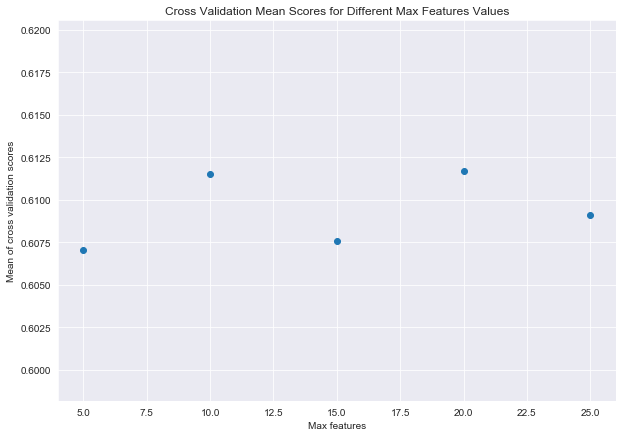

In [21]:
rfc_tfidf_svd_cv = []
for max_feat in [5,10,15,20,25]:
    rfc_tfidf_svd = RandomForestClassifier(max_features = max_feat, n_estimators=100, min_samples_split=2,max_depth=15)
    rfc_tfidf_svd.fit(X_train_tfidf_svd, y_train_tfidf_svd)
    rfc_tfidf_svd_cv.append(np.mean(cross_val_score(rfc_tfidf_svd, X_train_tfidf_svd, y_train_tfidf_svd, cv=5)))

plt.figure(figsize=(10,7))
plt.scatter([5,10,15,20,25], rfc_tfidf_svd_cv)
plt.xlabel('Max features')
plt.ylabel('Mean of cross validation scores')
plt.title('Cross Validation Mean Scores for Different Max Features Values')
plt.show()

Similar to above, I tuned the max features parameter using featuers created by tfidf.  I used the best max features value from the plot above and used it while I was tuning the max depth parameter below.

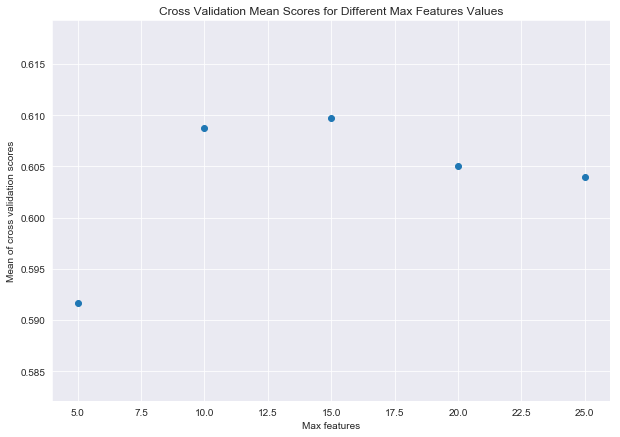

In [22]:
rfc_tfidf_svd_md = []
for md in [5,10,15,20,25]:
    rfc_tfidf_svd = RandomForestClassifier(max_features = 20, n_estimators=100, min_samples_split=2,max_depth=md)
    rfc_tfidf_svd.fit(X_train_tfidf_svd, y_train_tfidf_svd)
    rfc_tfidf_svd_md.append(np.mean(cross_val_score(rfc_tfidf_svd, X_train_tfidf_svd, y_train_tfidf_svd, cv=5)))

plt.figure(figsize=(10,7))
plt.scatter([5,10,15,20,25], rfc_tfidf_svd_md)
plt.xlabel('Max features')
plt.ylabel('Mean of cross validation scores')
plt.title('Cross Validation Mean Scores for Different Max Features Values')
plt.show()

In [23]:
rfc_tfidf_svd_test = RandomForestClassifier(max_features = 20, n_estimators=100, min_samples_split=2,max_depth=15)
rfc_tfidf_svd_test.fit(X_train_tfidf_svd, y_train_tfidf_svd)
print('Test scores using tuned RF classifier:',rfc_tfidf_svd_test.score(X_test_tfidf_svd, y_test_tfidf_svd))

Test scores using tuned RF classifier: 0.621


I ran the Random Forest Classifier on my hold out data set using the two parameters I tuned above. 

In [59]:
from sklearn.metrics import confusion_matrix

#svd_tfidf confusion matrix
print('tfidf svd confusion matrix:\n',confusion_matrix(y_test_tfidf_svd, rfc_tfidf_svd_test.predict(X_test_tfidf_svd)))
#svd bow confusion matrix
print('bow pca confusion matrix:\n',confusion_matrix(y_test_bow_pca, rfc_bow_pca_test.predict(X_test_bow_pca)))

tfidf svd confusion matrix:
 [[3805 2228]
 [2320 3647]]
bow pca confusion matrix:
 [[3670 2295]
 [2416 3619]]


In addition to cross validation, I used confusion matrix as an error metric.  The tfidf svd dataset has a higher number of true positives and true negatives. 